# AlexNet

## 前期设置

#### 导入需要用到的包

In [1]:
import os
import tarfile
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

#### 设置运算设备

CUDA™是一种由NVIDIA推出的通用并行计算架构，该架构使GPU能够解决复杂的计算问题。可以简单理解为CUDA = GPU。

In [2]:
torch.cuda.is_available()  # 检测当前环境下是否有可用的GPU设备

True

PyTorch中，tensor默认在CPU上存储和运算。若要将其转到GPU上，则可以使用.to('cuda')。要将已存储在GPU上的tensor转回CPU上，则可以使用.to('cpu')。

In [3]:
a = torch.tensor(1)  # 创建一个简单的tensor
print('tensor a:', a.device)  # 查看其所在设备

b = a.to('cuda')  # 转到GPU上
print('tensor b:', b.device)  # 查看其所在设备

c = b.to('cpu')  # 转回CPU上
print('tensor c:', c.device)  # 查看其所在设备

tensor a: cpu
tensor b: cuda:0
tensor c: cpu


若有可用的GPU设备，则设置变量device为'cuda'，否则为'cpu'。对之后代码中所有数据和模型参数使用.to(device)，就可以把它们转到我们想要的设备上。

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

#### 设置超参数

In [5]:
num_classes = 10  # 分类任务的类别数
batch_size = 32  # 每个小批次包含的样本数量
epochs = 5  # 训练周期数
lr = 1e-4  # 学习率

## 准备数据集

#### 导入数据集文件

若检测到未导入过数据集文件，则创建数据集存储路径，并将矩池云预置的数据集压缩文件解压至目标路径下。

In [6]:
if not os.path.exists('data/CIFAR-10'):  # 检测路径下是否已存在文件，若否，则执行以下代码
    os.mkdir('data/CIFAR-10')  # 创建数据存储路径，即data文件夹
    with tarfile.open('/public/keras_datasets/cifar-10-python.tar.gz') as tar:  # 矩池云上内置CIFAR-10数据集压缩文件的存储路径
        tar.extractall(path='data/CIFAR-10')  # 将数据集压缩文件解压，并保存至data文件夹中

#### 创建训练集、测试集

先使用torchvision.datasets中内置的CIFAR10类，将数据集文件转换为PyTorch中的数据集，并对其中的图片数据施加一定的预处理。接下来，使用DataLoader将数据集转化为分批次的数据读取器，可直接用于训练。

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 变形为AlexNet所需的输入形状（224 * 224）
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  # 进行打乱

testset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)  # 不进行打乱

#### 展示数据集样例

trainloader的格式比较特殊，直接使用trainloader[0]取其中第一个元素会报错。我们先将其转换为Python中的迭代器类型，再用next函数取其中第一个元素。

In [9]:
images, labels = next(iter(trainloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


查看训练集第一个批次中的图片。

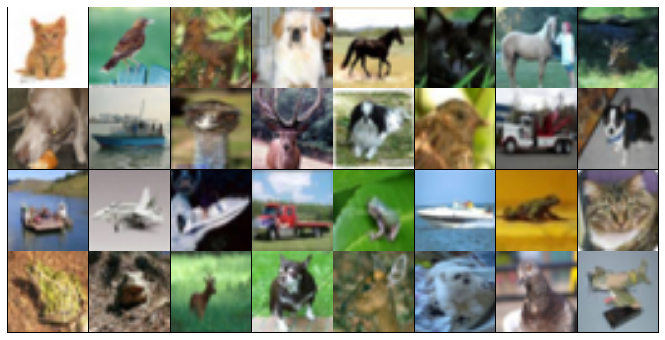

In [10]:
plt.figure(figsize=(12, 6))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

## 构建模型

借助PyTorch内置的nn.Sequential类构建模型。

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(48, 128, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(128, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(192, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(192, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(128 * 6 * 6, 2048),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, num_classes)
)

model.to(device)  # 将模型中所有参数tensor切换到GPU存储模式

model  # 展示模型的结构

Sequential(
  (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten()
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=4608, out_features=2048, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=2048, out_features=2048, bias=True)
  (19): ReLU()
  (20): Linear(in_features=2048, out_features=

## 模型训练

先定义几个训练中会用到的函数。

In [12]:
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

In [13]:
# 模型验证
def validate(model, testloader):
    val_loss = 0
    val_acc = 0
    
    model.eval()  # 模型切换到预测模式
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    
    model.train()  # 模型切换到训练模式
    
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    
    return val_loss, val_acc

In [14]:
# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [15]:
# 模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    model.train()  # 模型切换到训练模式
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
    
    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        train_acc = 0
        
        start = time.time()  # 记录本epoch开始时间
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式

            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）

            outputs = model(inputs)  # 计算模型输出

            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字

            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc

            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        
        train_loss /= len(trainloader)  # 计算平均损失
        train_acc /= len(trainloader)  # 计算平均准确率
        
        val_loss, val_acc = validate(model, testloader)  # 计算测试集上的损失函数和准确率
        
        print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果

输入参数epochs和lr，实施训练。

In [16]:
train(model, trainloader, testloader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/5], time: 56.76s, loss: 1.6539, acc: 0.3814, val_loss: 1.3020, val_acc: 0.5254
Epoch [2/5], time: 56.10s, loss: 1.2251, acc: 0.5537, val_loss: 1.0976, val_acc: 0.6036
Epoch [3/5], time: 56.11s, loss: 1.0338, acc: 0.6295, val_loss: 0.9318, val_acc: 0.6670
Epoch [4/5], time: 56.29s, loss: 0.8931, acc: 0.6835, val_loss: 0.8246, val_acc: 0.7101
Epoch [5/5], time: 56.04s, loss: 0.7842, acc: 0.7243, val_loss: 0.7478, val_acc: 0.7405


## 模型预测

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [17]:
# 模型预测
def predict(model, inputs):
    model.eval()  # 模型切换到预测模式
    outputs = model(inputs.to(device))
    preds = torch.max(outputs, dim=1)[1]
    return preds

In [18]:
testiter = iter(testloader)

每次对迭代器testiter执行next，就会取出其下一个元素。因此，多次运行以下代码块，即可测试不同的图片。

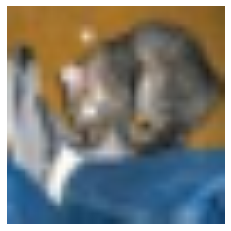

Prediction: cat


In [19]:
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(model, image.unsqueeze(dim=0))  # 由于模型接受的输入shape为4维（第1维为batch_size），因此需要使用unsqueeze函数在图片前面加一维
print('Prediction:', testset.classes[pred])